In [1]:
import wandb
import pandas as pd
import numpy as np
from scipy.stats import binomtest

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
alg_names = {
    "vmcts": "VerMCTS (ours)",
    "whole": "Whole sampling",
    "reflexion": "Reflexion",
    "rollout": "MCTS rollout",
}
colors = sns.color_palette("Set1", n_colors=4, ) # desat=.5)
color_names = dict(zip(alg_names.keys(), colors))

In [3]:
api = wandb.Api()
runs = api.runs(path="seas/vmcts")

In [4]:
# len(tree_df)

# Version for final stats

In [5]:
tree_df = pd.DataFrame()

tree_groups = ["vmcts-dafnychecks9-1"]

tree_keys = [
    "final/n_tokens",
    "final/width",
    "final/depth",
    "final/total_nodes",
    "final/max_value",
    "final/min_value",
    "tree/max_value",
    "tree/min_value",
    "tree/depth",
    "tree/max_child_count",
    "tree/widen_count",
    "tree/mean_value",
    "tree/width",
    "tree/node_depth",
    "tree/n_tokens",
]

keys = tree_keys
for run in runs:
    if run.group in tree_groups:
        if "repeat" in run.config["problem_name"] and "repeat" not in  run.group:
            continue
        history = run.summary
    
        run_dict = {}
        run_dict["id"] = run.id
        run_dict["group"] = run.group
        run_dict["alg"] = run.group.split("-")[0]
        run_dict["discovery_factor"] = run.config["discovery_factor"]
        run_dict["widen_policy_value"] = run.config["widen_policy_value"]
        run_dict["seed"] = run.config["seed"]
        run_dict["model_arg_temp"] = run.config["model_arg_temp"]
        run_dict["problem_name"] = run.config["problem_name"]

        if any([key not in history for key in keys]):
            continue
        for key in keys:
            run_dict[key] = history[key]
        run_df = pd.DataFrame(run_dict, index=[0])
        tree_df = pd.concat([tree_df, run_df])

In [6]:
len(tree_df)

794

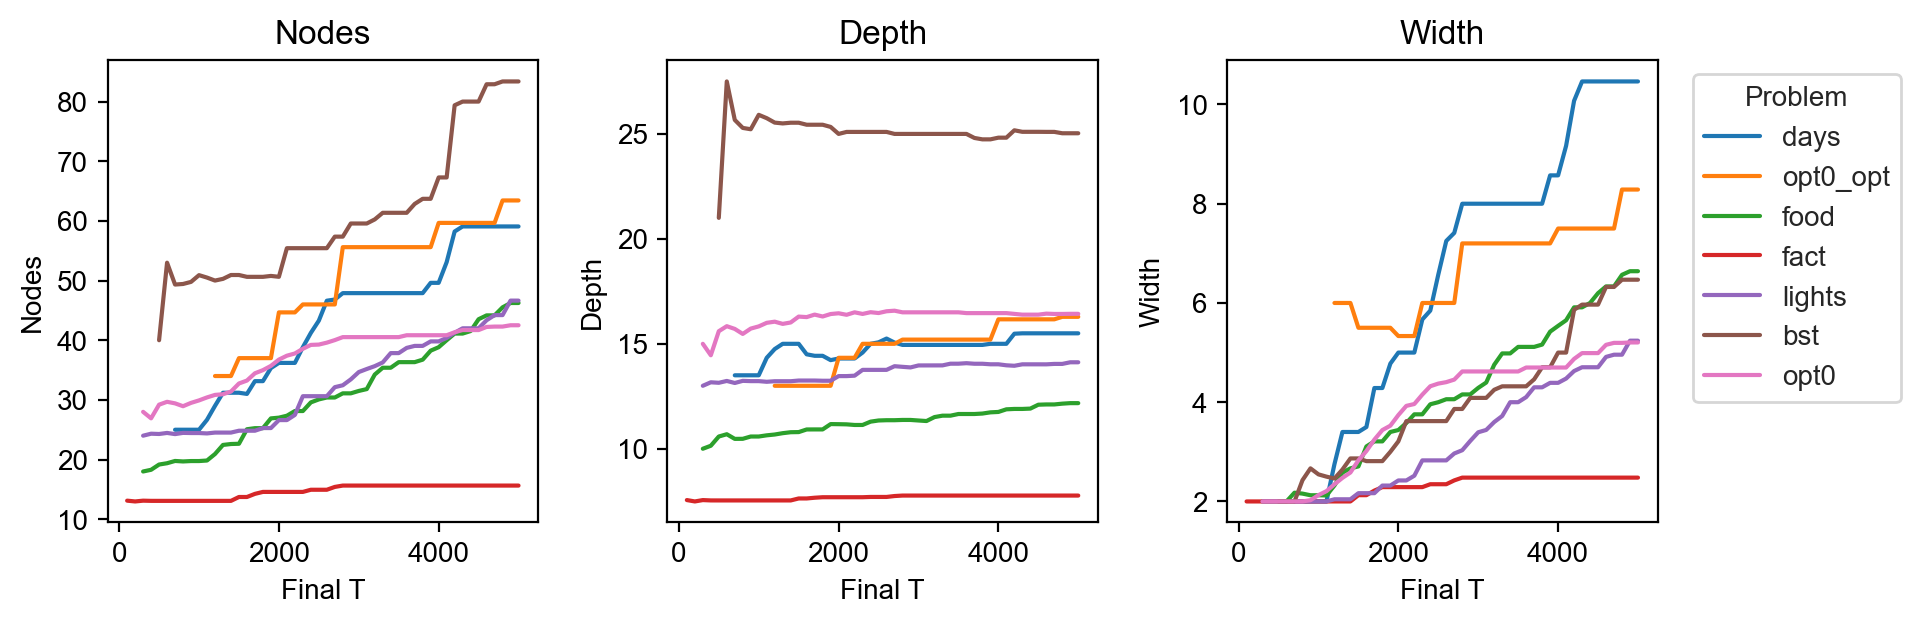

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=200)
sns.set_style("whitegrid")

fig.subplots_adjust(wspace=0.3)

colors = sns.color_palette("Set1", n_colors=3)

def plot(ax, key):
    for problem in tree_df["problem_name"].unique():
        if "reverse" in problem:
            continue
        problem_df = tree_df[tree_df["problem_name"] == problem]
        ts = range(100, 5001, 100)
        ys = []
        for i, t in enumerate(ts):
            pass_df = problem_df[problem_df [f"final/n_tokens"] <= t]
            ys.append(pass_df[key].mean())
        ax.plot(ts, ys, 
                label=problem.replace("_dafny_check", "").replace("problem_", "").replace("_more_check", ""))



ax = axs[0]
plot(ax, "final/total_nodes")
ax.set_title("Nodes")
ax.set_ylabel("Nodes")
ax.set_xlabel("Final T")


ax = axs[1]
plot(ax, "final/depth")
ax.set_title("Depth")
ax.set_ylabel("Depth")
ax.set_xlabel("Final T")


ax = axs[2]
plot(ax, "final/width")
ax.set_title("Width")
ax.set_ylabel("Width")
ax.set_xlabel("Final T")
ax.legend(loc="upper left", bbox_to_anchor=(1.05,1), title="Problem")

plt.show()

# Tokens vs width/depth (one line per problem)

In [17]:
tree_df = pd.DataFrame()

tree_groups = ["vmcts-dafnychecks9-1"]

tree_keys = [
    # "final/n_tokens",
    # "final/width",
    # "final/depth",
    # "final/total_nodes",
    # "final/max_value",
    # "final/min_value",
    "tree/max_value",
    "tree/min_value",
    "tree/depth",
    "tree/max_child_count",
    "tree/widen_count",
    "tree/mean_value",
    "tree/width",
    "tree/node_depth",
    "tree/n_tokens",
]

keys = tree_keys
for run in runs:
    if run.group in tree_groups:
        # if "repeat" in run.config["problem_name"] and "repeat" not in  run.group:
        #     continue
        history = run.history(samples=100, keys=keys)
    
        run_dict = {}
        run_dict["id"] = run.id
        run_dict["group"] = run.group
        run_dict["alg"] = run.group.split("-")[0]
        run_dict["discovery_factor"] = run.config["discovery_factor"]
        run_dict["widen_policy_value"] = run.config["widen_policy_value"]
        run_dict["seed"] = run.config["seed"]
        run_dict["model_arg_temp"] = run.config["model_arg_temp"]
        run_dict["problem_name"] = run.config["problem_name"]

        if any([key not in history for key in keys]):
            continue
        # for key in keys:
        #     run_dict[key] = history[key]
        # run_df = pd.DataFrame(run_dict, index=[0])
        
        run_df = history.assign(**{key: value for key, value in run_dict.items()})   

        max_tokens = max(run_df["tree/n_tokens"])
        # Add extra rows to data:
        for t in range(max_tokens, 5000, 100):
            run_df = pd.concat([run_df, run_df.iloc[[-1]]], ignore_index=True)
            run_df.iloc[-1, run_df.columns.get_loc("tree/n_tokens")] = t

        tree_df = pd.concat([tree_df, run_df])

In [18]:
tree_df.head()

,_step,tree/max_value,tree/min_value,tree/depth,tree/max_child_count,tree/widen_count,tree/mean_value,tree/width,tree/node_depth,tree/n_tokens,id,group,alg,discovery_factor,widen_policy_value,seed,model_arg_temp,problem_name
0,0,1,0,3,1,2,0.500000,2,1,8,z7cdshft,vmcts-dafnychecks9-1,vmcts,3.0,0.1,7,1.0,problem_days_dafny_check
1,1,2,0,4,2,3,0.833333,2,2,32,z7cdshft,vmcts-dafnychecks9-1,vmcts,3.0,0.1,7,1.0,problem_days_dafny_check
2,2,3,0,5,2,4,1.125000,2,3,44,z7cdshft,vmcts-dafnychecks9-1,vmcts,3.0,0.1,7,1.0,problem_days_dafny_check
3,3,4,0,6,2,5,1.400000,2,4,58,z7cdshft,vmcts-dafnychecks9-1,vmcts,3.0,0.1,7,1.0,problem_days_dafny_check
4,4,3,0,6,2,5,0.900000,2,5,89,z7cdshft,vmcts-dafnychecks9-1,vmcts,3.0,0.1,7,1.0,problem_days_dafny_check


In [19]:
len(tree_df)

77460

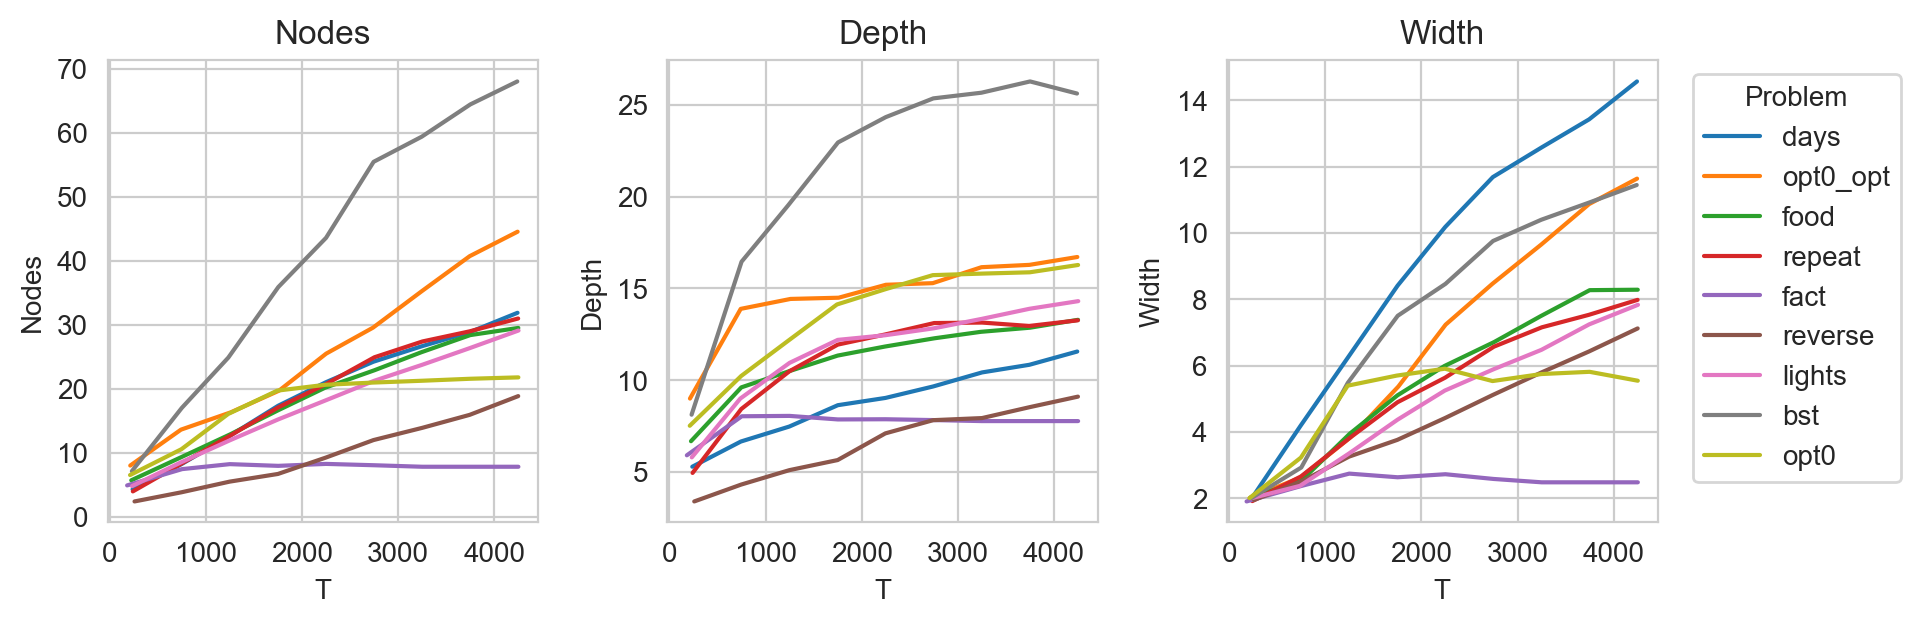

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=200)
sns.set_style("whitegrid")

fig.subplots_adjust(wspace=0.3)

colors = sns.color_palette("Set2", n_colors=6)

def plot(ax, key):
    for i, problem in enumerate(tree_df["problem_name"].unique()):
        problem_df = tree_df[tree_df["problem_name"] == problem]
        problem_df = problem_df[tree_keys]
        bins = np.arange(0, 5000, 500)
        problem_df['bins'] = pd.cut(problem_df['tree/n_tokens'], bins=bins, right=False)
        problem_df = problem_df.groupby('bins', observed=True).mean()

        problem_df = problem_df.sort_values('tree/n_tokens')
        ax.plot(problem_df['tree/n_tokens'], problem_df[key], 
                label=problem.replace("_dafny_check", "").replace("problem_", "").replace("_more_check", ""),
        )# color=colors[i])

ax = axs[0]
plot(ax, "tree/widen_count")
ax.set_title("Nodes")
ax.set_ylabel("Nodes")
ax.set_xlabel("T")


ax = axs[1]
plot(ax, "tree/depth")
ax.set_title("Depth")
ax.set_ylabel("Depth")
ax.set_xlabel("T")


ax = axs[2]
plot(ax, "tree/width")
ax.set_title("Width")
ax.set_ylabel("Width")
ax.set_xlabel("T")
ax.legend(loc="upper left", bbox_to_anchor=(1.05,1), title="Problem")

plt.show()